In [2]:
__author__ = "Islem Maboud"
__aka__ = "CoderOne"
__github__ = "https://github.com/ipenywis"
__link__ = "https://www.youtube.com/c/coderone"
__license__ = "MIT"
__version__ = "1.0.0"
__maintainer__ = "Islem Maboud"
__email__ = "islempenywis@gmail.com"


import numpy as np

import pandas as pd

#This will be used to use GoogleNews vectors
from gensim import models

from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Reshape, Flatten, concatenate, Input

from keras.models import Model

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical

from matplotlib import pyplot

import re

from os.path import isfile, join

import collections
import re
import string
import os
import nltk

Matplotlib is building the font cache; this may take a moment.


## Download Required Packages and Modes

In [17]:
## Downloading Required Packages and Models
#GOOGLE_NEWS_PATH = "./googleNews-word2vec"
GOOGLE_NEW_BIN_PATH = "./GoogleNews-vectors-negative300.bin"

#Github file is corrupted!
#!git clone "git@github.com:mmihaltz/word2vec-GoogleNews-vectors.git" $GOOGLE_NEWS_PATH

!wget -P $GOOGLE_NEW_BIN_PATH -c -nc "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

## Downloading Required Nltk processing packages

In [3]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /home/islempenywis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/islempenywis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Reading and Processing Data 

In [4]:
# Reading tweets from text file
datasetPath = './data/Tweets.txt'
tweetsData = pd.read_csv(datasetPath, header = None, delimiter='\t', encoding='utf-8-sig')
tweetsData.columns = ['Text', 'Label']
data = []

tweetsData.head()

,Text,Label
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,OBJ
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,POS
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,NEG
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,OBJ
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,NEUTRAL


## Adding labels as integers instead of strings

In [5]:
tweetsData.Label.unique()


array(['OBJ', 'POS', 'NEG', 'NEUTRAL'], dtype=object)

In [6]:
tweetsData.shape

(9694, 2)

In [8]:
pos = []
neg = []
obj = []
neutral = []
for l in tweetsData.Label:
    if l == 'OBJ':
        neg.append(0)
        pos.append(0)
        neutral.append(0)
        obj.append(1)
    elif l == 'NEUTRAL':
        neg.append(0)
        pos.append(0)
        neutral.append(1)
        obj.append(0)
    elif l == 'POS':
        neg.append(0)
        pos.append(1)
        neutral.append(0)
        obj.append(0)
    elif l == "NEG":
        neg.append(1)
        pos.append(0)
        neutral.append(0)
        obj.append(0)

tweetsData['Pos'] = pos
tweetsData['Neg'] = neg
tweetsData['Obj'] = obj
tweetsData['Neutral'] = neutral

tweetsData.head()

,Text,Label,Pos,Neg,Obj,Neutral
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,OBJ,0,0,1,0
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,POS,1,0,0,0
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,NEG,0,1,0,0
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,OBJ,0,0,1,0
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,NEUTRAL,0,0,0,1


## Cleaning Data

In [9]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

tweetsData['Text_Clean'] = tweetsData['Text'].apply(lambda x: remove_punct(x))
tweetsData.head()

,Text,Label,Pos,Neg,Obj,Neutral,Text_Clean
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,OBJ,0,0,1,0,بعد استقالة رئيس المحكمةالدستورية ننتظر استقال...
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,POS,1,0,0,0,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,NEG,0,1,0,0,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,OBJ,0,0,1,0,الحريةوالعدالة شاهد الآن ليلةالاتحادية أول في...
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,NEUTRAL,0,0,0,1,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...


In [10]:
# Tokenizing

from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in tweetsData.Text_Clean]

print(tokens[0:8])

[['بعد', 'استقالة', 'رئيس', 'المحكمةالدستورية', 'ننتظر', 'استقالة', 'رئيسالقضاء', 'السودان'], ['أهنئ', 'الدكتور', 'أحمد', 'جمال', 'الدين،', 'القيادي', 'بحزب', 'مصر،', 'بمناسبة', 'صدور', 'أولى', 'روايته'], ['البرادعي', 'يستقوى', 'بامريكا', 'مرةاخرى', 'و', 'يرسل', 'عصام', 'العريان', 'الي', 'واشنطن', 'شئ', 'مقرف'], ['الحريةوالعدالة', 'شاهد', 'الآن', 'ليلةالاتحادية', 'أول', 'فيلم', 'استقصائي', 'يتناول', 'أسرار', 'و', 'كواليس', 'تعرض', 'لأول', 'مرة', 'حول', 'حقيقة'], ['الوالدة', 'لو', 'اقولها', 'بخاطري', 'حشيشة', 'تضحك', 'بس', 'من', 'اقولها', 'ملل', 'الله', 'وكيلك', 'تعطيني', 'محاضرة', 'عن', 'الفسق', 'والفجور', 'بجنوب', 'الشيشان', 'ليه', 'كذا', 'يانبع', 'الحنان'], ['انتخبواالعرص', 'انتخبواالبرص', 'مرسىرئيسى', 'اينرئيسى', 'ö'], ['امير', 'عيد', 'هو', 'اللي', 'فعلا', 'يتقال', 'عليه', 'ستريكر', 'صريح', 'كاريوكي', 'السكةشمال'], ['أحكي', 'لكم', 'قصة', 'حدثت', 'بين', 'شاب', 'و', 'أحد', 'الفتيات', 'كان', 'بينهم', 'حب', 'كبير', 'ولكن', 'حدثت', 'غلطة', 'واحدة؟', 'فهل', 'ستستمر', 'هذه', 'القصة', 'ويتم

In [11]:
#Arabic Stopwords removal

from nltk.corpus import stopwords
stoplist = stopwords.words('arabic')

def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

filtered_words = [remove_stop_words(sen) for sen in tokens] 
result = [' '.join(sen) for sen in filtered_words]

tweetsData['Text_Final'] = result
tweetsData['tokens'] = filtered_words

#Leave only the needed data (remove the rest)
tweetsData = tweetsData[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg', 'Obj', 'Neutral']]

#Is it really removed? let's see
tweetsData[:5]

,Text_Final,tokens,Label,Pos,Neg,Obj,Neutral
0,استقالة رئيس المحكمةالدستورية ننتظر استقالة رئ...,"[استقالة, رئيس, المحكمةالدستورية, ننتظر, استقا...",OBJ,0,0,1,0
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,"[أهنئ, الدكتور, أحمد, جمال, الدين،, القيادي, ب...",POS,1,0,0,0
2,البرادعي يستقوى بامريكا مرةاخرى يرسل عصام العر...,"[البرادعي, يستقوى, بامريكا, مرةاخرى, يرسل, عصا...",NEG,0,1,0,0
3,الحريةوالعدالة شاهد ليلةالاتحادية فيلم استقصائ...,"[الحريةوالعدالة, شاهد, ليلةالاتحادية, فيلم, اس...",OBJ,0,0,1,0
4,الوالدة اقولها بخاطري حشيشة تضحك اقولها ملل ال...,"[الوالدة, اقولها, بخاطري, حشيشة, تضحك, اقولها,...",NEUTRAL,0,0,0,1


In [12]:
# Check the removed stopwords from tokens too
print(tweetsData.tokens[0:8])

0    [استقالة, رئيس, المحكمةالدستورية, ننتظر, استقا...
1    [أهنئ, الدكتور, أحمد, جمال, الدين،, القيادي, ب...
2    [البرادعي, يستقوى, بامريكا, مرةاخرى, يرسل, عصا...
3    [الحريةوالعدالة, شاهد, ليلةالاتحادية, فيلم, اس...
4    [الوالدة, اقولها, بخاطري, حشيشة, تضحك, اقولها,...
5    [انتخبواالعرص, انتخبواالبرص, مرسىرئيسى, اينرئي...
6    [امير, عيد, اللي, فعلا, يتقال, ستريكر, صريح, ك...
7    [أحكي, قصة, حدثت, شاب, الفتيات, بينهم, حب, كبي...
Name: tokens, dtype: object


## Splitting Data into Train and Test

In [13]:
data_train, data_test = train_test_split(tweetsData, test_size=0.10, random_state=42)

In [14]:
#Calculating the data size for training
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
#What's the size of the vocabulary for train? 
TRAINING_VOCAB = sorted(list(set(all_training_words)))

#Verbose info about our split datasets train
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

104183 words total, with a vocabulary size of 36438
Max sentence length is 825


In [15]:
#Calculating the data size for testing
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
#Again! What's the size of the vocabulary for test? 
TEST_VOCAB = sorted(list(set(all_test_words)))

#Verbose info about our split datasets test
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

11436 words total, with a vocabulary size of 7228
Max sentence length is 217


## Use Google News Word2Vec Model to create embeddings and have better results

  The idea behind this is using the word2vec model to create embeddings for each word in the dataset. This will help us to have better results when we try to predict the sentiment of a tweet. 

In [18]:
#Load google news bin
print(GOOGLE_NEW_BIN_PATH)
word2vec = models.KeyedVectors.load_word2vec_format("./GoogleNews-vectors-negative300.bin", binary=True)

./GoogleNews-vectors-negative300.bin


In [19]:
# Functions for manipulating and getting the embeddings 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

## Getting the actuall embeddings to the training dataset

In [20]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

## Next step we are going to Pad sequences and toknize them

In [21]:
# Using the Tokenizer to convert words to integers
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
#Finally extract the sequences from the generated tokens of the training data
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 36434 unique tokens.


In [22]:
# Extract the training data as padded sequences
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [23]:
# Get training data embedding weihgts
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

#How does the shape look like?
print(train_embedding_weights.shape)

(36435, 300)


In [24]:
#Let's do the same for the test data
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_cnn_data.size


48500

# Using RNN-LSTM

In [25]:
label_names = ['Pos', 'Neg', 'Obj', 'Neutral']

y_train = data_train[label_names].values

x_train = train_cnn_data
y_tr = y_train

## Definning Our CNN-LSTM Model

In [26]:
# The reason we did a function is we may want to use it later without replicating the same code
# The function will create all the model layers and return the model at the end
def recurrent_nn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

#     lstm = LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embedded_sequences)
    lstm = LSTM(256)(embedded_sequences)
    
    x = Dense(128, activation='relu')(lstm)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [27]:
# Creating our Model
model = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

2021-12-10 23:47:50.727869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-10 23:47:50.727909: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 23:47:50.727939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ispenws-ubuntu): /proc/driver/nvidia/version does not exist
2021-12-10 23:47:50.728331: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 23:47:50.828602: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 43722000 exc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 300)           10930500  
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 11,534,280
Trainable params: 603,780
Non-traina

## Training the RNN-LSTM Model

In [32]:
num_epochs = 5
batch_size = 256

train_hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/5
31/31 [==============================] - 11s 359ms/step - loss: 0.4017 - acc: 0.6687 - val_loss: 0.4101 - val_acc: 0.6621
Epoch 2/5
31/31 [==============================] - 11s 353ms/step - loss: 0.4001 - acc: 0.6683 - val_loss: 0.3988 - val_acc: 0.6621
Epoch 3/5
31/31 [==============================] - 12s 380ms/step - loss: 0.3980 - acc: 0.6695 - val_loss: 0.3998 - val_acc: 0.6621
Epoch 4/5
31/31 [==============================] - 11s 360ms/step - loss: 0.3994 - acc: 0.6687 - val_loss: 0.3949 - val_acc: 0.6621
Epoch 5/5
31/31 [==============================] - 11s 346ms/step - loss: 0.3950 - acc: 0.6669 - val_loss: 0.3958 - val_acc: 0.6621


## Testing the Trained RNN-LSTM Model

In [29]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
labels = ["POS", "NEG", "OBJ", "NEUTRAL"]

predictions.shape

prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

2021-12-10 23:49:25.924130: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 58200000 exceeds 10% of free system memory.


1/1 [==============================] - 1s 986ms/step


## What's the accuracy of the model when running against the test data

In [30]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.6608247422680412

## Ploting the ROC for Accuracy for Train and Test

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


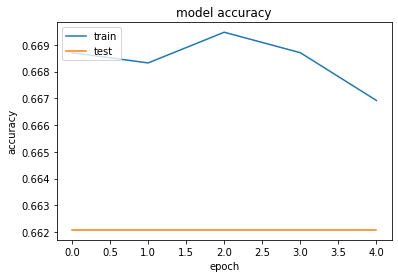

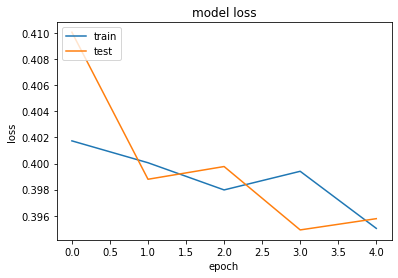

In [35]:
import matplotlib.pyplot as plt


# list all data in history
print(train_hist.history.keys())
# summarize history for accuracy
plt.plot(train_hist.history['acc'])
plt.plot(train_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train_hist.history['loss'])
plt.plot(train_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()